In [34]:
from foba_backtest_engine.components.order_book.utils.foba_own_orders import order_numbers_filtered, order_state_creates, order_matches, order_deletes, order_delete_matches, get_optiver_trades,optiver_trade_and_quotes
from foba_backtest_engine.components.order_book.utils.foba_competitor_broker_queue import omdc_order_number_to_broker_number, competitor_enrichment, foreign_counterparty_enrichment, broker_orders_enrichment
from foba_backtest_engine.components.order_book.utils.foba_feedstates import fetch_feed_stats_from_book_builders, full_feed_state_enrichment, feed_states_at_join
from foba_backtest_engine.components.order_book.utils.foba_time import TimeProfile, MinSentTime, MaxSentTime,AverageSentTime,omdc_profile, send_times
from foba_backtest_engine.components.order_book.utils.foba_misc_enrichments import category_enrichment, derived_enrichment
from foba_backtest_engine.components.order_book.utils.foba_hk_broker_data_fetch import omdc_broker_number_to_name
from foba_backtest_engine.components.order_book.utils.foba_omdc_broker_queue_processor import omdc_broker_queue
from foba_backtest_engine.components.order_book.processors.foba_extract_foba_events import extract_foba_events
from foba_backtest_engine.components.order_book.utils.foba_fee_enrichment import static_data_enrichment
from foba_backtest_engine.components.order_book.utils.foba_static_data_info import static_data_info
from foba_backtest_engine.components.order_book.utils.foba_credit_enricher import event_enricher
from foba_backtest_engine.components.order_book.utils.foba_slippages import annotate_slippages
from foba_backtest_engine.maintained_configs.HKEX_symbol_map import STOCK_SYMBOLS, SYMBOL_BOOK
from foba_backtest_engine.components.order_book.processors.foba_book_builder import pybuilders
from foba_backtest_engine.components.order_book.utils.foba_pnl_enrichment import enrich_pnl
from foba_backtest_engine.data.S3.S3OptiverResearchActions import OPTIVER_BUCKET_ACTIONS
from foba_backtest_engine.components.order_book.utils.foba_trades import optiver_trades
from foba_backtest_engine.utils.base_utils import get_logger, ImmutableRecord
from foba_backtest_engine.components.order_book.utils.enums import Exchange
from foba_backtest_engine.utils.time_utils import start_end_time
from foba_backtest_engine.enrichment import Enrichment, configure
import pandas as pd
from datetime import datetime

In [35]:
from foba_backtest_engine.data.S3.S3OptiverResearchActions import OPTIVER_BUCKET_ACTIONS
from foba_backtest_engine.utils.base_utils import ImmutableDict, get_logger, ImmutableRecord, multi_dict
from foba_backtest_engine.components.order_book.utils import MyRow as MyRow
from foba_backtest_engine.components.order_book.utils.enums import Side, ProductClass, EventType
from foba_backtest_engine.enrichment import provides, id_dict, enriches
from collections import namedtuple, defaultdict
from operator import attrgetter
from itertools import chain
import datetime as dt
import pandas as pd
import numpy as np
import re


In [36]:
SYMBOLS  = {
    5: 'HSB',
    3988: 'BOC'
}

In [37]:
max_workers = 5
pybuilder_exchange = Exchange.OMDC
currency_rate = 1.0
book_ids = list(SYMBOLS.keys())
date_to_inspect = datetime(2024,1,31)
days_ago = 0
time_zone = 'Asia/Hong_Kong'
end_hour = 16
end_minute = 1
exclude_pulls = False
include_only_optiver_pulls = True
exclude_inplace_updates = False
book_build_parallel = True
sent_times=(
            MinSentTime(omdc_profile),
            MaxSentTime(omdc_profile),
            AverageSentTime(
                TimeProfile(
                    min_one_way_delay=-float('inf'),
                    min_round_trip_delay=float(0.36e6),
                    max_one_way_delay=float('inf'),
                    max_round_trip_delay=float(0.50e6))
                        )
                    )
annotation_min_change=0.001
exclude_lunch=True
pnl_slippage_times=[5,15,30,60,120,240,300,600,900,1800,3600,7200]
bbov_weights=[1,6,6,1]
smooth_bbov_alpha=0.10
bbov_interval_s=10

In [38]:
start_time, end_time = start_end_time(time_zone=time_zone,
                                          days_ago=days_ago,
                                          start_hour=6,
                                          start_minute=0,
                                          end_hour=end_hour,
                                          end_minute=end_minute,
                                          end_date=date_to_inspect)
        
filter_used = ImmutableRecord(start_time=start_time, end_time=end_time, book_ids=book_ids)

In [39]:
date_to_inspect, feedcodes = filter_used.start_time.datetime, filter_used.book_ids

In [7]:
feedcodes = [str(x) if isinstance(x, int) else x for x in feedcodes]

In [40]:
order_num_filtered = order_numbers_filtered(filter_used)

In [41]:
len(order_num_filtered)

268

In [42]:
pybuilds = pybuilders(pybuilder_exchange, filter_used, optiver_order_numbers=order_num_filtered)

2024-10-20 16:21:20,722 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Started
2024-10-20 16:21:20,722 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Timerange - 2024-01-31 06:00:00-2024-01-31 16:01:00
2024-10-20 16:21:20,723 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: feed_update_count - 77432
2024-10-20 16:21:23,975 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.1
2024-10-20 16:21:26,807 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.2
2024-10-20 16:21:29,735 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete

In [43]:
foba_events = extract_foba_events(pybuilds, filter_used, exclude_pulls=False, include_only_optiver_pulls=True, optiver_order_numbers=order_num_filtered)

In [52]:
sdi = static_data_info()

In [53]:
sde = static_data_enrichment(foba_events, sdi)

In [54]:
st = send_times(foba_events, sent_times)

In [72]:
fs = fetch_feed_stats_from_book_builders(pybuilds)

In [75]:
slippages = annotate_slippages(fs, [5,15,30,60,120,240,300,600,900,1800,3600,7200])

In [78]:
ffse = full_feed_state_enrichment(foba_events, fs, slippages)

In [82]:
fsaj = feed_states_at_join(foba_events, fs, slippages)

In [83]:
len(fsaj)

10384

In [89]:
feedcodes = [str(x) if isinstance(x, int) else x for x in feedcodes]

5

In [172]:
osc = order_state_creates(filter_used)

In [208]:
om = order_matches(foba_events, osc, fsaj)

In [220]:
od = order_deletes(filter_used)

In [230]:
odm = order_delete_matches(foba_events, od, ffse)

In [233]:
bntn = omdc_broker_number_to_name()

In [238]:
def get_merged_trades(date_to_inspect, feedcodes, broker_number_to_broker_name):
    feedcodes = [str(x) if isinstance(x, int) else x for x in feedcodes]
    private_trades = fetch_order_info(date_to_inspect, feedcodes, data_store = "core_trades", operation='private_trade', mic='XHKG')
    trade_confirms = fetch_one_tick(date_to_inspect, feedcodes)
    combined = pd.merge(
        private_trades, 
        trade_confirms,
        left_on=["private_trade_key"], 
        right_on=["UNIQUE_TRADE_ID"]
    )
    combined["COUNTERPARTY_BROKER_ID"] = combined["COUNTERPARTY_BROKER_ID"].astype("int")
    combined["SUBMITTING_BROKER_ID"] = combined["SUBMITTING_BROKER_ID"].astype("int")
    mapping = {
        "trade_time":"exchange_timestamp",
        "exchange_order_id" : "orderId_",
        "feedcode" : "bookId_",
        "FEEDCODE" : "feedcode",
        "LOG_TIME" : "received_",
        "SENDING_TIME_EPOCH" : "add_order_timestamp_",
        "COUNTERPARTY_BROKER_ID" : "counterpartyId_",
        "EXCHANGE_TRADE_ID" : "exchangeTradeId_",
        "SUBMITTING_BROKER_ID" : "optiverBrokerId_"
    }
    
    combined = combined.rename(columns = mapping)
    combined = combined[["exchange_timestamp", "orderId_", "bookId_", "feedcode", "username", "portfolio", "received_", "price", "volume", "optiver_side", "optiver_side", "dd_group_key", "add_order_timestamp_", "counterpartyId_", "exchangeTradeId_", "optiverBrokerId_"]]
    
    addOrders = fetch_order_info(date_to_inspect, feedcodes)
    addOrders = addOrders.rename(columns={
        "exchange_order_id":"orderId_",
        "feedcode":"bookId_"})
    addOrders['orderId_'] = pd.to_numeric(addOrders['orderId_'].replace(['', ' '], np.nan), errors='coerce').astype('Int64')
    order_type_dict = dict(zip(addOrders['orderId_'], addOrders['lifespan']))
    if ((len(combined) == 0) | (len(order_type_dict) == 0)):
        pass
    else:
        combined["order_type"] = combined["orderId_"].map(order_type_dict)
        combined["optiver_hit"] = np.where(combined["order_type"] == "FAK", True, False)

    return combined


In [239]:
combined = get_merged_trades(date_to_inspect, feedcodes, bntn)

In [242]:
combined["optiver_hit"].value_counts()

optiver_hit
False    1399
Name: count, dtype: int64

In [261]:
optiver_trades = get_optiver_trades(filter_used, bntn)

In [304]:
opti_hit_quotes = optiver_trade_and_quotes(filter_used, foba_events, optiver_trades, odm)

AttributeError: 'collections.defaultdict' object has no attribute 'remove'

In [296]:
opti_hits = []
opti_quotes = []
others = []
for eventId, event in opti_hit_quotes.items():
    if event.optiver_hit == True:
        opti_hits.append(event)
    elif (event.optiver_hit == False) & (event.optiver_trade == True):
        opti_quotes.append(event)
    else:
        others.append(event)

In [305]:
hit_optis = []
quote_optis = []
for eventId, event in optiver_trades.items():
    if event.optiver_hit:
        hit_optis.append(event)
    else:
        quote_optis.append(event)

In [309]:
hit_optis[0].keys()

dict_keys(['exchange_timestamp', 'orderId_', 'bookId_', 'feedcode', 'username', 'portfolio', 'received_', 'price', 'volume', 'optiver_side', 'dd_group_key', 'add_order_timestamp_', 'counterpartyId_', 'exchangeTradeId_', 'optiverBrokerId_', 'order_type', 'optiver_hit'])

In [324]:
pd.to_datetime(hit_optis[0].exchange_timestamp)

Timestamp('2024-01-31 01:35:13.634427')

In [ ]:
1706664600007000000
1706664913634427000

In [313]:
eventTs =[c.event_exchange_timestamp for i,c in foba_events.items()]

In [317]:
import matplotlib.pyplot as plt

In [326]:
hits = multi_dict([trade for trade in optiver_trades.values() if trade.optiver_hit == True], key=lambda trade : (trade.bookId_, Side.ASK if trade.optiver_side=="Buy" else Side.BID, abs(trade.price * trade.volume)))

In [ ]:
hit_key = (event.book_id, event.side, abs(event.event_price * event.aggressor_volume))

In [327]:
counter = 0
for event_id, event in foba_events.items():
    if counter > 0:
        break
    else:
        pass

    hit_key = (event.book_id, event.side, abs(event.event_price * event.aggressor_volume))
    if hit_key in hits:
        possible_matches = hits[hit_key]
        timestamps = [t.exchange_timestamp for t in possible_matches]
        print(event.event_exchange_timestamp)
        index = timestamps.index(min(timestamps, key = lambda x : abs(x-event.event_exchange_timestamp)))
        counter = 1



1706664605013000000


In [328]:
possible_matches

In [330]:
[x-1706664605013000000 for x in timestamps]

[309178693000, 309178693000, 536587250000, 536587250000]

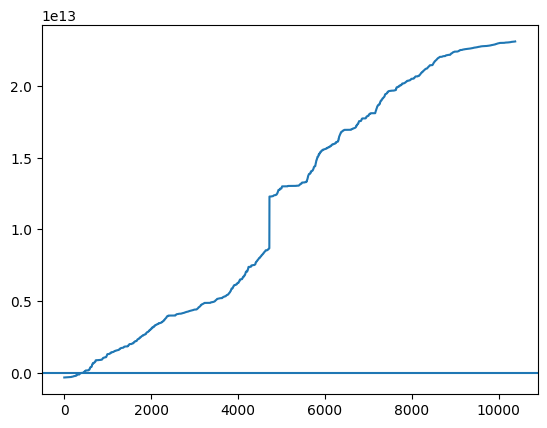

In [325]:
plt.plot([c - hit_optis[0].exchange_timestamp for c in sorted(eventTs)])
plt.axhline(0)

In [323]:
eventTs

[1706664600007000000,
 1706664600174000000,
 1706664600186000000,
 1706664601737000000,
 1706664602245000000,
 1706664602245000000,
 1706664603006000000,
 1706664603009000000,
 1706664603009000000,
 1706664604345000000,
 1706664604345000000,
 1706664604345000000,
 1706664604345000000,
 1706664605007000000,
 1706664605013000000,
 1706664605013000000,
 1706664606006000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664606007000000,
 1706664607132000000,
 1706664607132000000,
 1706664607132000000,
 1706664607132000000,
 1706664607132000000,
 1706664607133000000,
 1706664607133000000,
 1706664607133000000,
 1706664607133000000,
 1706664607133000000,
 1706664607133000000,
 1706664607164000000,
 1706664607205000000,
 1706664607205000000,
 1706664607607000000,
 1706664608005000000,
 1706664608027000000,
 1706664608143000000,
 1706664608143000000,
 1706664608143000000,
 170666460

In [319]:
hit_optis[0].exchange_timestamp

1706664913634427000